# DQN

## Implement Models

In [20]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import collections
from collections import namedtuple, deque
import numpy as np

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class FCModel(nn.Module):
    """Dense neural net for Q-value approximation."""
    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.net(x)

class QNetwork:
    def __init__(self, env, lr):
        input_size = env.observation_space.shape[0]
        output_size = env.action_space.n
        self.net = FCModel(input_size, output_size)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)

### Develop the replay buffer for adding experiences in buffers.

In [15]:
class ReplayMemory:
    def __init__(self, env, memory_size=50000, burn_in=10000):
        self.memory = deque(maxlen=memory_size)
        self.env = env
        self.burn_in = burn_in

    def __len__(self):
        return len(self.memory)

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self, batch_size=32):
        return random.sample(self.memory, batch_size)

    def burn_in_memory(self):
        state, _ = self.env.reset()
        while len(self.memory) < self.burn_in:
            action = self.env.action_space.sample()
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            self.memory.append(
                Transition(
                    torch.tensor([state], dtype=torch.float32),
                    torch.tensor([[action]], dtype=torch.int64),
                    None if done else torch.tensor([next_state], dtype=torch.float32),
                    torch.tensor([reward], dtype=torch.float32)
                )
            )
            state = next_state if not done else self.env.reset()[0]


### Policy module for selecting best action in given states. (Note: you can add the update_epsilone function to update the epsilone for each iteration)

In [16]:
class Policy:
    def __init__(self, env, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995):
        self.env = env
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

    def select_action(self, state, q_network, training=True):
        if training and random.random() < self.epsilon:
            a = self.env.action_space.sample()
            return torch.tensor([[a]], dtype=torch.int64)
        else:
            with torch.no_grad():
                return torch.argmax(q_network.net(state), dim=1).view(1, 1)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


### Develop Agent for DQN alghorithm. This module is reponsbile for training, testing, fill the buffer and optimize the learning.

In [28]:
class DQNAgent:
    def __init__(self, env_name, lr=1e-4, gamma=0.99, batch_size=128,
                 target_update=10, memory_size=50000, burn_in=10000,
                 epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995):

        self.env = gym.make(env_name)
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update

        self.policy_net = QNetwork(self.env, lr)
        self.target_net = QNetwork(self.env, lr)
        self.target_net.net.load_state_dict(self.policy_net.net.state_dict())

        self.memory = ReplayMemory(self.env, memory_size, burn_in)
        self.policy = Policy(self.env, epsilon_start, epsilon_end, epsilon_decay)

        self.steps_done = 0
        self.burn_in = burn_in

    def _optimize_model(self):
        if len(self.memory) < self.batch_size:
            return 0.0  # Skip if not enough samples

        transitions = self.memory.sample_batch(self.batch_size)
        batch = Transition(*zip(*transitions))

        # Prepare batches
        non_final_mask = torch.tensor([s is not None for s in batch.next_state], dtype=torch.bool)
        non_final_next = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Q(s_t, a)
        state_values = self.policy_net.net(state_batch).gather(1, action_batch)

        # Double DQN: use policy net to select best action, target net to evaluate
        next_state_values = torch.zeros(self.batch_size)
        with torch.no_grad():
            next_actions = self.policy_net.net(non_final_next).argmax(1, keepdim=True)
            next_q_values = self.target_net.net(non_final_next).gather(1, next_actions).squeeze()
            next_state_values[non_final_mask] = next_q_values

        # TD target
        expected = reward_batch + (self.gamma * next_state_values)

        # Compute loss (Huber loss is more stable than MSE)
        loss_fn = nn.SmoothL1Loss()
        loss = loss_fn(state_values, expected.unsqueeze(1))

        # Optimize
        self.policy_net.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.net.parameters(), max_norm=1.0)
        self.policy_net.optimizer.step()

        return loss.item()

    def train(self):
        if len(self.memory) < self.burn_in:
            self.memory.burn_in_memory()

        state, _ = self.env.reset()
        state = torch.tensor([state], dtype=torch.float32)
        total_reward = 0
        total_loss = 0
        steps = 0

        done = False
        while not done:
            action = self.policy.select_action(state, self.policy_net, training=True)
            ns, reward, terminated, truncated, _ = self.env.step(action.item())
            done = terminated or truncated
            next_state = None if done else torch.tensor([ns], dtype=torch.float32)

            self.memory.append(Transition(state, action, next_state, torch.tensor([reward], dtype=torch.float32)))
            state = next_state if next_state is not None else torch.tensor(self.env.reset()[0], dtype=torch.float32).unsqueeze(0)
            total_reward += reward
            loss = self._optimize_model()
            total_loss += loss
            steps += 1

        self.policy.update_epsilon()
        if self.steps_done % self.target_update == 0:
            self.target_net.net.load_state_dict(self.policy_net.net.state_dict())
        self.steps_done += 1

        return total_reward, total_loss / steps if steps > 0 else 0, steps

    def test(self, render=False):
        state, _ = self.env.reset()
        state = torch.tensor([state], dtype=torch.float32)
        total_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                action = torch.argmax(self.policy_net.net(state), dim=1).view(1, 1)
            ns, reward, terminated, truncated, _ = self.env.step(action.item())
            done = terminated or truncated
            state = torch.tensor([ns], dtype=torch.float32)
            total_reward += reward
            if render:
                self.env.render()

        return total_reward


  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0
The test reward for episode 0 is 72.8 with a standard deviation of 60.264915166288915.
Episode: 10
The test reward for episode 10 is 9.2 with a standard deviation of 0.6782329983125268.
Episode: 20
The test reward for episode 20 is 9.4 with a standard deviation of 0.9165151389911681.
Episode: 30
The test reward for episode 30 is 204.8 with a standard deviation of 26.949211491247755.
Episode: 40
The test reward for episode 40 is 257.25 with a standard deviation of 24.33284816867931.
Episode: 50
The test reward for episode 50 is 256.75 with a standard deviation of 33.0104150231408.
Episode: 60
The test reward for episode 60 is 276.6 with a standard deviation of 81.42198720247498.
Episode: 70
The test reward for episode 70 is 220.65 with a standard deviation of 63.241027031508594.
Episode: 80
The test reward for episode 80 is 185.95 with a standard deviation of 39.28037041576874.
Episode: 90
The test reward for episode 90 is 182.85 with a standard deviation of 43.14889917483411

 20%|██        | 1/5 [00:34<02:16, 34.05s/it]

Episode: 0
The test reward for episode 0 is 9.2 with a standard deviation of 0.6782329983125268.
Episode: 10
The test reward for episode 10 is 9.35 with a standard deviation of 0.6538348415311012.
Episode: 20
The test reward for episode 20 is 9.35 with a standard deviation of 0.6538348415311012.
Episode: 30
The test reward for episode 30 is 9.45 with a standard deviation of 0.6689544080129824.
Episode: 40
The test reward for episode 40 is 16.4 with a standard deviation of 6.995712972957081.
Episode: 50
The test reward for episode 50 is 258.15 with a standard deviation of 32.850076103412604.
Episode: 60
The test reward for episode 60 is 268.0 with a standard deviation of 74.51174404078863.
Episode: 70
The test reward for episode 70 is 218.95 with a standard deviation of 40.28706368054143.
Episode: 80
The test reward for episode 80 is 268.7 with a standard deviation of 74.0912275509051.
Episode: 90
The test reward for episode 90 is 216.05 with a standard deviation of 49.82215872480838.
E

 40%|████      | 2/5 [01:04<01:36, 32.15s/it]

Episode: 0
The test reward for episode 0 is 137.65 with a standard deviation of 59.86173652676641.
Episode: 10
The test reward for episode 10 is 9.0 with a standard deviation of 0.7745966692414834.
Episode: 20
The test reward for episode 20 is 11.85 with a standard deviation of 1.1521718621802912.
Episode: 30
The test reward for episode 30 is 29.4 with a standard deviation of 3.638681079732051.
Episode: 40
The test reward for episode 40 is 239.05 with a standard deviation of 11.052036011522944.
Episode: 50
The test reward for episode 50 is 288.05 with a standard deviation of 40.28458141770869.
Episode: 60
The test reward for episode 60 is 194.85 with a standard deviation of 15.473444994570537.
Episode: 70
The test reward for episode 70 is 138.05 with a standard deviation of 15.615617182807732.
Episode: 80
The test reward for episode 80 is 202.85 with a standard deviation of 72.42394286422136.
Episode: 90
The test reward for episode 90 is 206.9 with a standard deviation of 60.0365721872

 60%|██████    | 3/5 [01:43<01:10, 35.04s/it]

Episode: 0
The test reward for episode 0 is 9.65 with a standard deviation of 0.47696960070847283.
Episode: 10
The test reward for episode 10 is 9.1 with a standard deviation of 0.8306623862918076.
Episode: 20
The test reward for episode 20 is 9.4 with a standard deviation of 0.5830951894845301.
Episode: 30
The test reward for episode 30 is 18.25 with a standard deviation of 6.6398418655868605.
Episode: 40
The test reward for episode 40 is 63.1 with a standard deviation of 13.030349189488362.
Episode: 50
The test reward for episode 50 is 282.35 with a standard deviation of 61.73918933708153.
Episode: 60
The test reward for episode 60 is 189.25 with a standard deviation of 33.868680222293875.
Episode: 70
The test reward for episode 70 is 185.6 with a standard deviation of 44.026582878983476.
Episode: 80
The test reward for episode 80 is 195.5 with a standard deviation of 49.63516898329248.
Episode: 90
The test reward for episode 90 is 190.95 with a standard deviation of 53.4859561006438

 80%|████████  | 4/5 [02:18<00:35, 35.15s/it]

Episode: 0
The test reward for episode 0 is 9.25 with a standard deviation of 0.6224949798994366.
Episode: 10
The test reward for episode 10 is 9.45 with a standard deviation of 0.8046738469715539.
Episode: 20
The test reward for episode 20 is 9.45 with a standard deviation of 0.9205976319760985.
Episode: 30
The test reward for episode 30 is 500.0 with a standard deviation of 0.0.
Episode: 40
The test reward for episode 40 is 283.15 with a standard deviation of 107.12622228007483.
Episode: 50
The test reward for episode 50 is 301.6 with a standard deviation of 65.33329931971905.
Episode: 60
The test reward for episode 60 is 238.75 with a standard deviation of 53.855245798343546.
Episode: 70
The test reward for episode 70 is 193.75 with a standard deviation of 47.04984059484155.
Episode: 80
The test reward for episode 80 is 217.15 with a standard deviation of 54.47685288266935.
Episode: 90
The test reward for episode 90 is 173.9 with a standard deviation of 45.649644029280225.
Episode: 

100%|██████████| 5/5 [03:00<00:00, 36.07s/it]


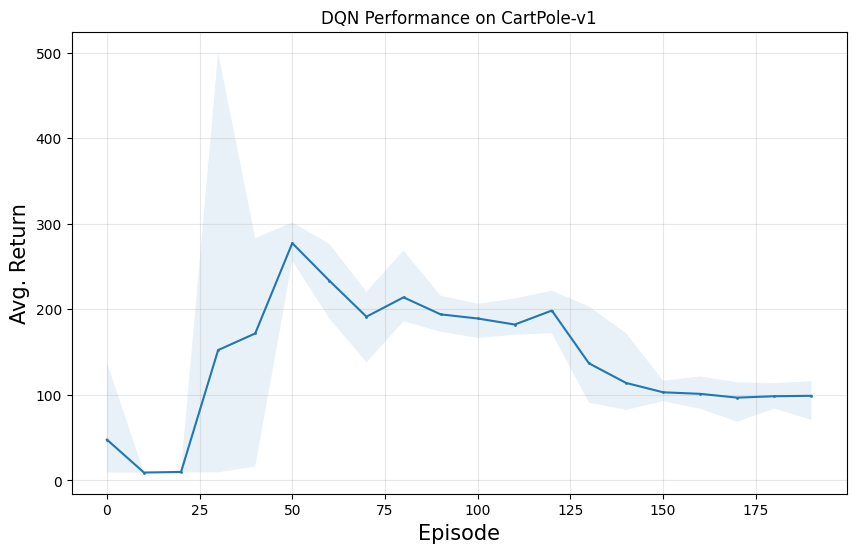

In [30]:
# Note: Feels free for adjust andy hyper paramter you want for trainin. Except these: seed, env_name, state_space_size
import matplotlib.pyplot as plt

if __name__ == "__main__":
    env_name = 'CartPole-v1'
    num_episodes_train = 200
    num_episodes_test = 20
    learning_rate = 5e-4

    env = gym.make(env_name)
    action_space_size = env.action_space.n
    state_space_size = 4

    num_seeds = 5
    l = num_episodes_train // 10
    res = np.zeros((num_seeds, l))
    gamma = 0.99

    for i in tqdm.tqdm(range(num_seeds)):
        reward_means = []
        agent = DQNAgent(env_name, lr=learning_rate, gamma=gamma)

        for m in range(num_episodes_train):
            episode_reward, episode_loss, steps = agent.train()

            if m % 10 == 0:
                print(f"Episode: {m}")

                G = np.zeros(num_episodes_test)
                for k in range(num_episodes_test):
                    g = agent.test()
                    G[k] = g

                reward_mean = G.mean()
                reward_sd = G.std()
                print(f"The test reward for episode {m} is {reward_mean} with a standard deviation of {reward_sd}.")
                reward_means.append(reward_mean)

        res[i] = np.array(reward_means)

    ks = np.arange(l) * 10
    avs = np.mean(res, axis=0)
    maxs = np.max(res, axis=0)
    mins = np.min(res, axis=0)

    plt.figure(figsize=(10, 6))
    plt.fill_between(ks, mins, maxs, alpha=0.1)
    plt.plot(ks, avs, '-o', markersize=1)

    plt.xlabel('Episode', fontsize=15)
    plt.ylabel('Avg. Return', fontsize=15)
    plt.title('DQN Performance on CartPole-v1')
    plt.grid(True, alpha=0.3)
    plt.savefig('dqn_performance.png')
    plt.show()

## Answer these questions:

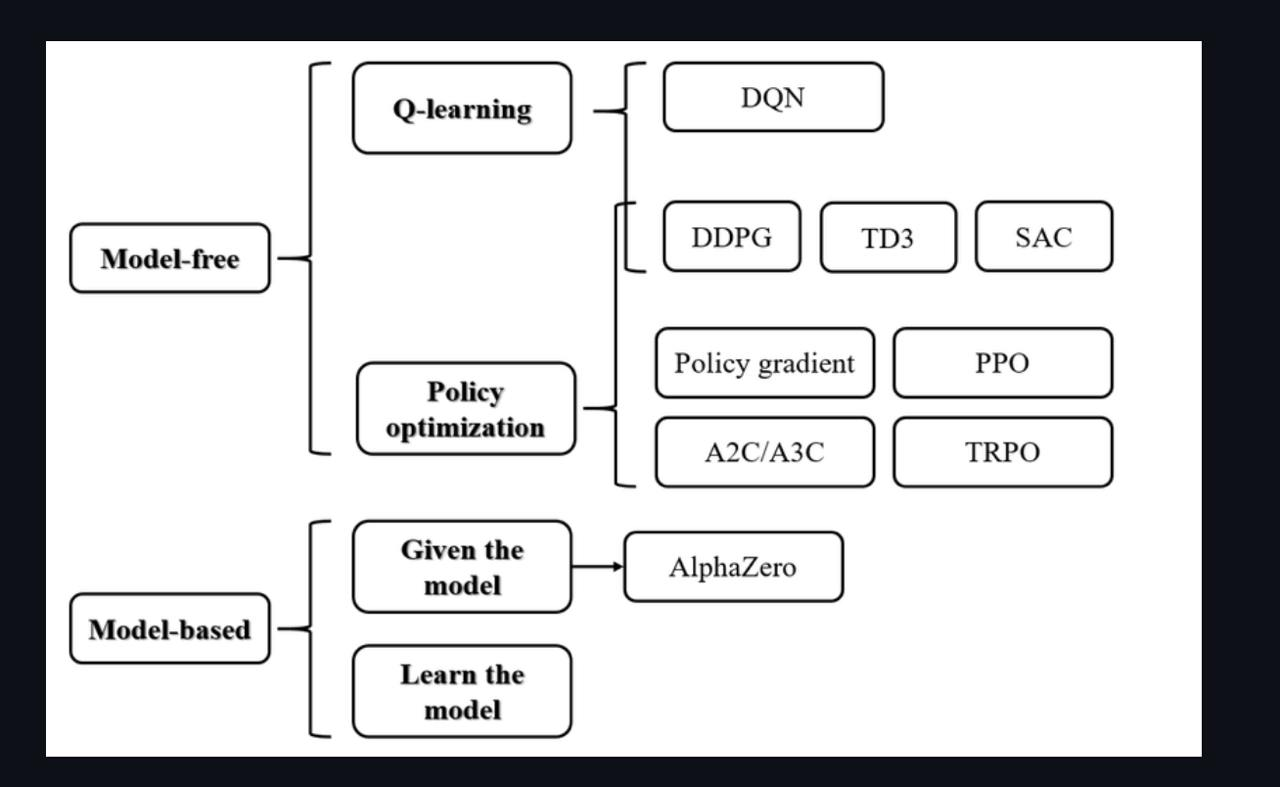

Q1) According given image, explain the value based, policy based apporches in MODEL FREE.

- Value‑Based Methods

  - Learn an action‑value function Q(s, a) that estimates expected return of taking action a in state s and thereafter following an (implicit) policy.
  - The agent selects actions by maximizing this learned Q (e.g. π(s) = arg max_a Q(s, a)).
  - Example: Q‑learning and DQN.

- Policy‑Based Methods

  - Directly parameterize a stochastic policy πθ(a ∣ s) and optimize θ to maximize expected return J(θ).
  - No explicit value function is required (though many variants use a critic).
  - Example: REINFORCE, PPO, A2C/A3C.

Q2) The DQN you implemented is consider which one of those? why? what is rule of the Policy Class you implemented?

- DQN is a value-based, model-free algorithm: it learns a neural approximation of Q(s, a) and acts greedily (with exploration).

- Our Policy class implements the ε-greedy exploration mechanism:
  - With probability ε: select a random action (exploration).
  - Otherwise: select $ \text{arg} \max_a Q(s, a)$ (exploitation).

- It also decays ε over time to shift gradually from exploration to exploitation.


Q3) Explain the rule of Replay Buffer in algorithm. (why we should use this?)

- Breaks Temporal Correlation: stores transitions $ (s, a, r, s') $ in a large buffer and samples mini-batches uniformly.

- Stabilizes Training: repeatedly re-uses past experiences, smoothing gradient updates and reducing variance.

- Improves Data Efficiency: each transition contributes to multiple gradient steps rather than being discarded immediately.


Q4) Explain the rule of epsilon

- Controls Exploration–Exploitation Trade-off:
  - **High ε** → more random actions → thorough exploration of state-action space.
  - **Low ε** → more greedy actions → exploitation of learned Q.

- Decay Schedule: ε is annealed (e.g. multiplicative decay) from an initial high value (e.g. **1.0**) to a minimum floor (e.g. **0.05**), ensuring sufficient exploration early and stable exploitation later.


# SAC

## Implement SAC

Implement SAC with (Cart-pole) enviroment.

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from collections import deque, namedtuple
import random

# — Transition tuple & replay buffer —
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayBuffer:
    def __init__(self, BUFFER_CAP):
        self.buf = deque(maxlen=BUFFER_CAP)
    def append(self, *args):
        self.buf.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buf)

# — Discrete actor (categorical) —
class CategoricalActor(nn.Module):
    def __init__(self, s_dim, a_dim):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(s_dim, 512), nn.ReLU(),
        nn.Linear(512, 512), nn.ReLU(),
        nn.Linear(512, a_dim)
        )

    def forward(self, s):
        logits = self.net(s)
        dist   = torch.distributions.Categorical(logits=logits)
        a      = dist.sample().unsqueeze(-1)           # shape (batch,1)
        logp   = dist.log_prob(a.squeeze(-1)).unsqueeze(-1)
        return a, logp

# — Q‑network for discrete actions (outputs Q(s,·) for all a) —
class CriticDiscrete(nn.Module):
    def __init__(self, s_dim, a_dim):
        super().__init__()
        self.q = nn.Sequential(
            nn.Linear(s_dim,256), nn.ReLU(),
            nn.Linear(256,256), nn.ReLU(),
            nn.Linear(256,a_dim)
        )
    def forward(self, s):
        return self.q(s)  # shape (batch, a_dim)

# — Single SAC update for discrete actions —
def sac_update():
    batch = buffer.sample(BATCH_SIZE)
    # States
    s  = torch.tensor(batch.state,      dtype=torch.float32)        # (B, S)
    # Actions: ensure long dtype and shape (B, 1)
    a  = torch.tensor(batch.action,     dtype=torch.int64).unsqueeze(1)
    # Rewards, next states, dones
    r  = torch.tensor(batch.reward,     dtype=torch.float32).unsqueeze(1)
    s2 = torch.tensor(batch.next_state, dtype=torch.float32)
    d  = torch.tensor(batch.done,       dtype=torch.float32).unsqueeze(1)

    # 1) Compute target Q
    with torch.no_grad():
        a2, logp2 = actor(s2)                                 # a2: (B,1), logp2: (B,1)
        q1_t_all  = target1(s2)                               # (B, A_DIM)
        q2_t_all  = target2(s2)
        # gather along dim=1 using the new action indices
        q1_t = q1_t_all.gather(1, a2.long())
        q2_t = q2_t_all.gather(1, a2.long())
        q_targ = torch.min(q1_t, q2_t) - log_alpha.exp() * logp2
        y = r + GAMMA * (1 - d) * q_targ                      # (B,1)

    # 2) Critic loss
    q1_all = critic1(s)                                       # (B, A_DIM)
    q2_all = critic2(s)
    # Gather the Q‐values for the actions actually taken
    q1 = q1_all.gather(1, a)                                  # now both (B,1)
    q2 = q2_all.gather(1, a)
    loss_q = nn.MSELoss()(q1, y) + nn.MSELoss()(q2, y)

    opt_critic.zero_grad()
    loss_q.backward()
    opt_critic.step()

    # 5) Soft update of targets
    for p, tp in zip(critic1.parameters(), target1.parameters()):
        tp.data.mul_(POLYAK); tp.data.add_((1-POLYAK)*p.data)
    for p, tp in zip(critic2.parameters(), target2.parameters()):
        tp.data.mul_(POLYAK); tp.data.add_((1-POLYAK)*p.data)

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


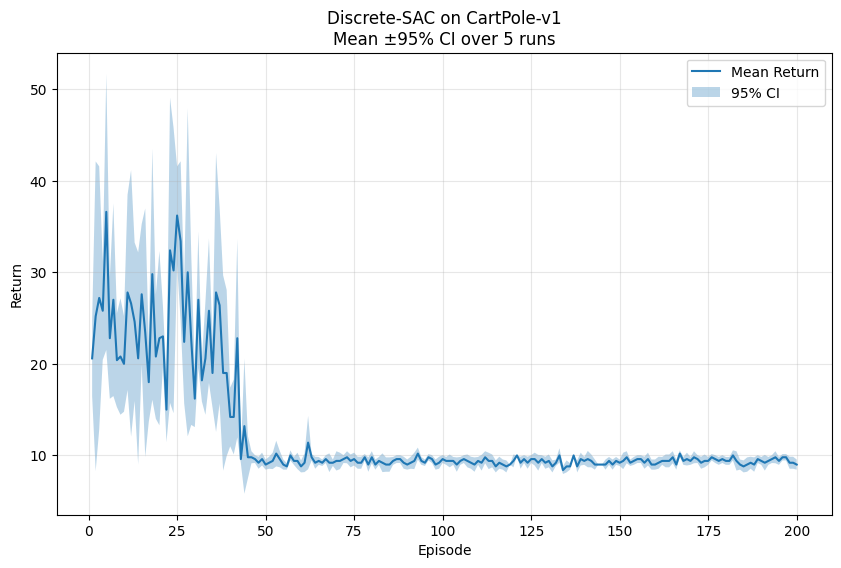

In [6]:
import torch.nn as nn
from collections import deque, namedtuple
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import random

def set_seed(seed, env):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    env.reset(seed=seed)
    env.action_space.seed(seed)

# — Hyperparameters —
n_runs      = 5
n_episodes  = 200
max_steps   = 500          # CartPole’s cap per episode
START_STEPS = 1_000
LR_ACTOR    = 3e-3
LR_CRITIC   = 3e-4
LR_ALPHA    = 3e-3
GAMMA       = 0.99
POLYAK      = 0.995
BATCH_SIZE  = 256
BUFFER_CAP  = 100_000

all_rewards = []

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    seed = 100 + run
    env  = gym.make('CartPole-v1')
    set_seed(seed, env)

    # — Re‑instantiate networks, buffer, optimizers, etc. —
    S_DIM = env.observation_space.shape[0]
    A_DIM = env.action_space.n

    actor       = CategoricalActor(S_DIM, A_DIM)
    critic1     = CriticDiscrete(S_DIM, A_DIM)
    critic2     = CriticDiscrete(S_DIM, A_DIM)
    target1     = CriticDiscrete(S_DIM, A_DIM)
    target2     = CriticDiscrete(S_DIM, A_DIM)
    target1.load_state_dict(critic1.state_dict())
    target2.load_state_dict(critic2.state_dict())

    opt_actor   = optim.Adam(actor.parameters(), lr=LR_ACTOR)
    opt_critic  = optim.Adam(list(critic1.parameters()) + list(critic2.parameters()), lr=LR_CRITIC)
    log_alpha   = torch.zeros(1, requires_grad=True)
    opt_alpha   = optim.Adam([log_alpha], lr=LR_ALPHA)

    buffer = ReplayBuffer(BUFFER_CAP)

    # redefine sac_update here so it closes over the right locals
    def sac_update():
        batch = buffer.sample(BATCH_SIZE)
        s   = torch.tensor(batch.state,      dtype=torch.float32)
        a   = torch.tensor(batch.action,     dtype=torch.int64).unsqueeze(1)
        r   = torch.tensor(batch.reward,     dtype=torch.float32).unsqueeze(1)
        s2  = torch.tensor(batch.next_state, dtype=torch.float32)
        d   = torch.tensor(batch.done,       dtype=torch.float32).unsqueeze(1)

        with torch.no_grad():
            a2, logp2    = actor(s2)
            q1_t_all     = target1(s2)
            q2_t_all     = target2(s2)
            q1_t         = q1_t_all.gather(1, a2.long())
            q2_t         = q2_t_all.gather(1, a2.long())
            q_targ       = torch.min(q1_t, q2_t) - log_alpha.exp() * logp2
            y            = r + GAMMA * (1 - d) * q_targ

        q1_all = critic1(s)
        q2_all = critic2(s)
        q1      = q1_all.gather(1, a)
        q2      = q2_all.gather(1, a)
        loss_q  = nn.MSELoss()(q1, y) + nn.MSELoss()(q2, y)

        opt_critic.zero_grad()
        loss_q.backward()
        opt_critic.step()

        a_new, logp_new = actor(s)
        q1_new = critic1(s).gather(1, a_new)
        q2_new = critic2(s).gather(1, a_new)
        loss_pi = (log_alpha.exp() * logp_new - torch.min(q1_new, q2_new)).mean()

        opt_actor.zero_grad()
        loss_pi.backward()
        opt_actor.step()

        loss_alpha = -(log_alpha * (logp_new + (-np.log(1.0/A_DIM)*0.98)).detach()).mean()
        opt_alpha.zero_grad()
        loss_alpha.backward()
        opt_alpha.step()

        for p, tp in zip(critic1.parameters(), target1.parameters()):
            tp.data.mul_(POLYAK); tp.data.add_((1-POLYAK)*p.data)
        for p, tp in zip(critic2.parameters(), target2.parameters()):
            tp.data.mul_(POLYAK); tp.data.add_((1-POLYAK)*p.data)

    # — Training loop per episode —
    rewards = []
    total_steps = 0

    for ep in range(n_episodes):
        state, _ = env.reset()
        ep_reward = 0

        for t in range(max_steps):
            st = torch.tensor([state], dtype=torch.float32)
            a, _ = actor(st)
            a_np = int(a.item())

            next_s, r, term, trunc, _ = env.step(a_np)
            done = term or trunc
            buffer.append(state, a_np, next_s, r, done)

            state = next_s
            ep_reward += r
            total_steps += 1

            if total_steps > START_STEPS:
                for _ in range(4):
                  sac_update()

            if done:
                break

        rewards.append(ep_reward)

    env.close()
    all_rewards.append(rewards)

# — Aggregate & plot —
all_rewards = np.array(all_rewards)
means = all_rewards.mean(axis=0)
stds  = all_rewards.std(axis=0)
ci    = 1.96 * stds / np.sqrt(n_runs)
eps   = np.arange(1, n_episodes+1)

plt.figure(figsize=(10,6))
plt.plot(eps, means, label='Mean Return')
plt.fill_between(eps, means-ci, means+ci, alpha=0.3, label='95% CI')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Discrete‑SAC on CartPole-v1\nMean ±95% CI over 5 runs')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Questions

Q1) Plot the average return with 5 different seed, mean and std.

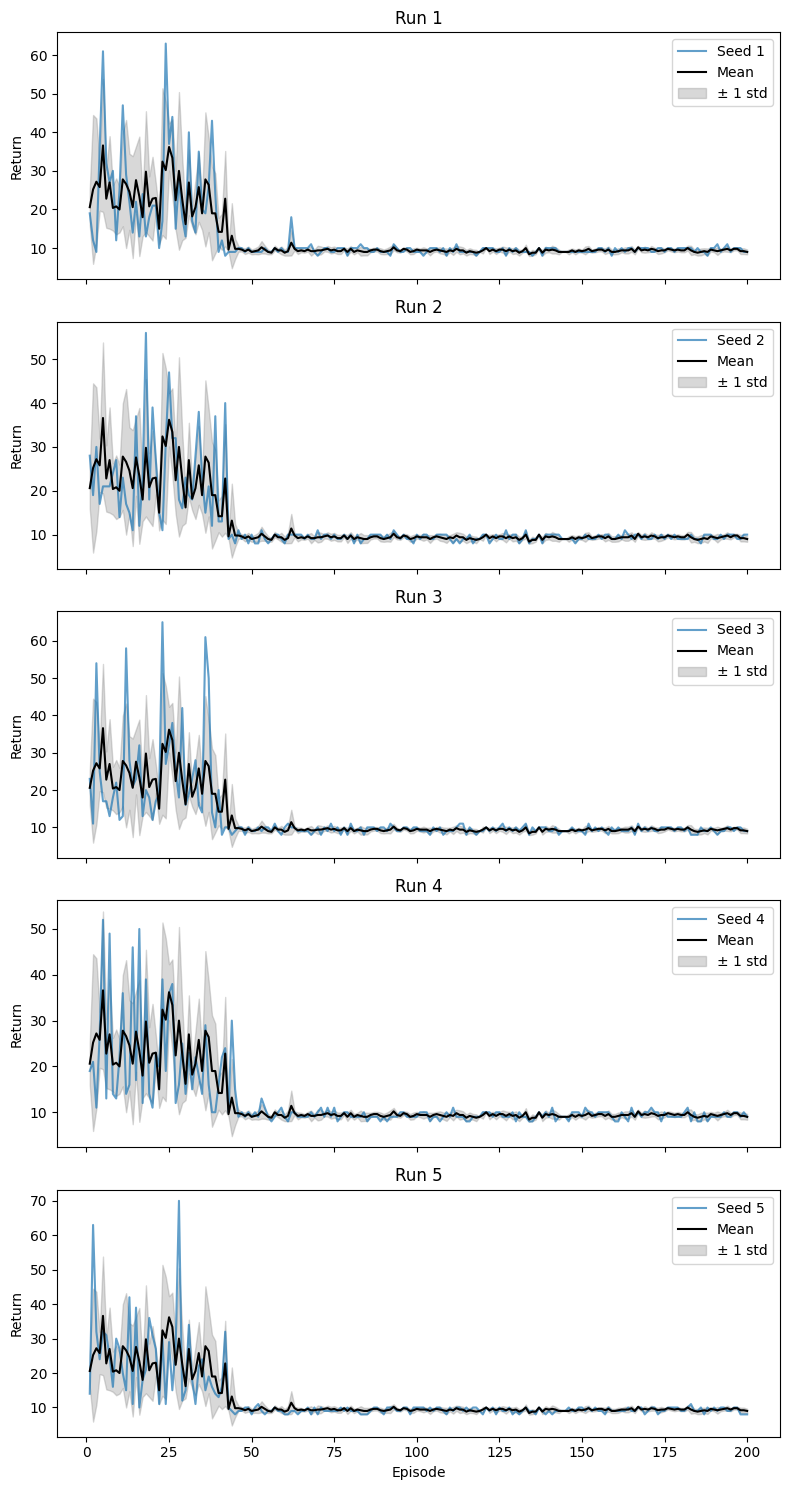

In [7]:
n_runs, N_EPISODES = all_rewards.shape
episodes = np.arange(1, N_EPISODES + 1)

# Compute mean and std across seeds
mean_rewards = all_rewards.mean(axis=0)
std_rewards  = all_rewards.std(axis=0)

# One subplot per seed
fig, axes = plt.subplots(n_runs, 1, figsize=(8, 3*n_runs), sharex=True)

for i in range(n_runs):
    ax = axes[i]
    # Plot this seed's curve
    ax.plot(episodes, all_rewards[i],
            label=f'Seed {i+1}', alpha=0.7)
    # Overlay mean
    ax.plot(episodes, mean_rewards,
            color='black', linewidth=1.5,
            label='Mean')
    # Shade ±1 std
    ax.fill_between(episodes,
                    mean_rewards - std_rewards,
                    mean_rewards + std_rewards,
                    color='gray', alpha=0.3,
                    label='± 1 std')
    ax.set_title(f'Run {i+1}')
    ax.set_ylabel('Return')
    ax.legend(loc='upper right')

axes[-1].set_xlabel('Episode')
plt.tight_layout()
plt.show()


Q2) Explain the SAC algorithm; what is different between SAC and DQN?

- **Action space**:  
  - **DQN** is a value-based, off-policy method for discrete actions—approximates **Q(s, a)** with a single network and selects **arg max\_a Q**.

  - **SAC** is an actor-critic algorithm designed for continuous (and discrete) spaces. It learns both a stochastic policy (actor) and **soft Q**-functions (critics).

- **Exploration strategy**:  
  - **DQN** uses an explicit **ε-greedy** heuristic to inject randomness.

  - **SAC** incorporates maximum-entropy regularization into its objective, so the policy remains naturally stochastic, trading off reward and entropy automatically.

- **Stability & bias**:  
  - **DQN** can suffer from overestimation of **Q**-values (mitigated by **Double-DQN**).

  - **SAC** uses twin critics and takes the minimum of two target **Q** estimates to reduce positive bias.

- **Objective**:  
  - **DQN** minimizes a Bellman error:  
  **(Q(s, a) − [r + γ max\_a Q(s', a)])²**.

  - **SAC** jointly optimizes:  
  $J\_Q = E[(Q(s, a) − y)²]$ ,  
  $J\_π = E[α log π(a|s) − Q(s, a)]$,  
  plus an automatic temperature update for $α$.


Q3) According to the diagram which is given in the previous question, how is SAC categorized?

According to that taxonomy, **Soft Actor‑Critic (SAC)** falls under the **Model‑Free → Q‑Learning (value‑based)** branch—in other words, it’s a model‑free, off‑policy, value‑based algorithm. It extends the basic Q‑learning/DQN idea by learning both a soft (entropy‑regularized) Q‑function and a stochastic policy simultaneously, but in the diagram it’s grouped alongside DDPG and TD3 under the value‑based (Q‑learning) subtree.

Q4) Explain each components in SAC, and functionality.

### SAC Components & Their Roles

| Component                  | Functionality                                                                                                                    |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| **Replay Buffer**          | Stores transitions $(s, a, r, s', d)$, breaks temporal correlations, and enables off-policy learning.                         |
| **Actor (Policy) Network** | Parameterizes a stochastic policy $\pi_\theta(a)$.                                                                             |
| **Twin Critics**           | Two Q-networks $Q_{\phi 1}$ and $Q_{\phi 2}$ estimate state-action values. Taking the minimum of their target estimates reduces overestimation bias. |
| **Target Critic Networks** | Polyak-averaged copies of the twin critics $(\phi^{targ}_i)$, updated slowly for stable targets $y$.                       |
| **Entropy Temperature (α)**| A scalar weight on the policy’s entropy bonus. Automatically tuned by minimizing $-\alpha[\log\pi(a|s)]$.                  |

#### Critic Loss

$$
J_Q = E_{s,a,r,s'}\left(Q_{\phi}(s,a) - \left[r + \gamma \left(\min_i Q^{targ}_i(s', a') - \alpha \log \pi(a'|s')\right)\right]\right)^2
$$

Optimizes the twin critics to match a “soft” Bellman backup.

#### Actor Loss

$$
J_\pi = E_s\left[\alpha \log \pi_\theta(a|s) - \min_i Q_{\phi i}(s,a)\right]
$$

Encourages selecting actions that both maximize value and maintain entropy.

#### Alpha Loss

$$
J_\alpha = E_s\left[-\alpha\left(\log \pi_\theta(a|s) + H_{target}\right)\right]
$$

Adjusts $\alpha$ so that the policy’s entropy approaches a desired target.

#### Polyak Averaging

Updates each target critic’s parameters via:

$$
\theta^{targ} \leftarrow \tau \theta^{targ} + (1 - \tau) \theta
$$

Provides smooth, slowly‑moving targets.
